In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [10]:
# set directory paths
root = '../../..'
images_dir = os.path.join(root, 'data/subset_valid/images/')
gt_bbox_dir = os.path.join(root, 'data/subset_valid/gt/')
pred_bbox_dir = os.path.join(root, 'data/subset_valid/pred/')

In [11]:
# set constants
gt_format = 'xywh_norm'
pred_format = 'x1y1x2y2_norm'
iou_thres = 0.0
output_path = 'subset_validation.csv'

In [12]:
image_fn = os.listdir(images_dir)
pred_bbox_fn = os.listdir(pred_bbox_dir)
gt_bbox_fn = os.listdir(gt_bbox_dir)

In [13]:
def parse_txt (label_fp, format_bbox, dataset):
    """Obtain x_min, y_min, x_max, and y_max of bounding box from txt file
    Args:
        label_fp (str): filepath to bounding box .txt file in detect.py output format
        format_bbox: 'x1y1x2y2' or 'xywh_norm' or 'x1y1x2y2_norm'
        dataset: 'predicted' or 'ground_truth'
    Returns:
        coords (numpy array)
        conf (float, returned only if dataset == 'predicted')
    """
    if format_bbox == 'x1y1x2y2':
        with open(label_fp, 'r') as label:
            line = str(label.readline())
            if len(line) == 0:
                return None
            else:
                vals = line.split(' ')
                x_min = int(vals[0])
                y_min = int(vals[1])
                x_max = int(vals[2])
                y_max = int(vals[3])
                coords = np.array([x_min, y_min, x_max, y_max])
                if dataset == 'ground_truth':
                    return coords
                elif dataset == 'predicted':
                    conf = float(vals[5])
                    conf = '%.4f'%(conf)
                    return coords, conf
    if format_bbox == 'x1y1x2y2_norm':
        with open(label_fp, 'r') as label:
            line = str(label.readline())
            if len(line) == 0:
                return None
            else:
                vals = line.split(' ')
                x_min = int(float(vals[0]) * 419)
                y_min = int(float(vals[1]) * 419)
                x_max = int(float(vals[2]) * 419)
                y_max = int(float(vals[3]) * 419)
                coords = np.array([x_min, y_min, x_max, y_max])
                if dataset == 'ground_truth':
                    return coords
                elif dataset == 'predicted':
                    conf = float(vals[5])
                    conf = '%.4f'%(conf)
                    return coords, conf
    elif format_bbox == 'xywh_norm':
        with open(label_fp, 'r') as label:
            line = str(label.readline())
            if len(line) == 0:
                return None
            else:
                vals = line.split(' ')
                norm_x = float(vals[1])
                norm_y = float(vals[2])
                norm_w = float(vals[3])
                norm_h = float(vals[4])
                x_min = int((norm_x * 419) - ((norm_w * 419) / 2))
                y_min = int((norm_y * 419) - ((norm_h * 419) / 2))
                x_max = int((norm_x * 419) + ((norm_w * 419) / 2))
                y_max = int((norm_y * 419) + ((norm_h * 419) / 2))
                coords = np.array([x_min, y_min, x_max, y_max])
                if dataset == 'ground_truth':
                    return coords
                elif dataset == 'predicted':
                    conf = float(vals[5])
                    conf = '%.4f'%(conf)
                    return coords, conf

In [14]:
def calc_IoU (ground_truth, predicted):
    """Calculate IoU of single predicted and ground truth box
    Args:
        pred_box (list of ints): location of predicted object as [xmin, ymin, xmax, ymax]
        gt_box (list of ints): location of ground truth object as [xmin, ymin, xmax, ymax]
    Returns:
        float: value of the IoU for the two boxes.
    """
    # gather gt and pred coords
    x1_t, y1_t, x2_t, y2_t = ground_truth
    x1_p, y1_p, x2_p, y2_p = predicted
    # make sure the bounding boxes overlap
    if (x2_p < x1_t) | (x2_t < x1_p) | (y2_p < y1_t) | (y2_t < y1_p):
        return 0
    else:
        # find extremes
        far_x = np.min([x2_t, x2_p])
        near_x = np.max([x1_t, x1_p])
        far_y = np.min([y2_t, y2_p])
        near_y = np.max([y1_t, y1_p])
        # calc areas
        inter_area = (far_x - near_x + 1) * (far_y - near_y + 1)
        gt_box_area = (x2_t - x1_t + 1) * (y2_t - y1_t + 1)
        pred_box_area = (x2_p - x1_p + 1) * (y2_p - y1_p + 1)
        # calc IoU
        iou = inter_area / (gt_box_area + pred_box_area - inter_area)
        #iou = float('%.4f'%(iou))
        return iou

In [15]:
def calc_CT_IoU (bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.
    Adapted from: https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation
    Args:
        bb1: [x1,y1,x2,y2]
        bb2: [x1,y1,x2,y2]    
    The (x1, y1) position is at the top left corner (or the bottom right - either way works).
    The (x2, y2) position is at the bottom right corner (or the top left).
    Returns:
        intersection_over_union, a float in [0, 1]
    """
    assert bb1[0] < bb1[2]
    assert bb1[1] < bb1[3]
    assert bb2[0] < bb2[2]
    assert bb2[1] < bb2[3]
    # Determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    # Compute the area of both AABBs
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])
    # Compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the intersection area.
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [16]:
# create dictionaries of ground_truth bboxes,  predicted bboxes, and confidence
ground_truth_dict = {}
for fn in gt_bbox_fn:
    bbox = parse_txt(os.path.join(gt_bbox_dir, fn), gt_format, 'ground_truth')
    ground_truth_dict[fn.replace('.txt', '.png')] = bbox
predicted_dict = {}
conf_dict = {}
for fn in pred_bbox_fn:
    bbox, conf = parse_txt(os.path.join(pred_bbox_dir, fn), pred_format, 'predicted')
    predicted_dict[fn.replace('.txt', '.png')] = bbox
    conf_dict[fn.replace('.txt', '.png')] = conf

In [17]:
# build dataframe of image, ground_truth bboxes, predicted bboxes, and confidence
data = {'image' : image_fn}
detect_df = pd.DataFrame(data, columns=['image'])
print('created dataframe')
detect_df['ground_truth'] = detect_df['image'].map(pd.Series(ground_truth_dict))
print('added ground truth boxes')
detect_df['predicted'] = detect_df['image'].map(pd.Series(predicted_dict))
print('added predicted boxes')
detect_df['confidence'] = detect_df['image'].map(pd.Series(conf_dict))
print('added confidence')

created dataframe
added ground truth boxes
added predicted boxes
added confidence


In [18]:
# add ground_truth bbox size to dataframe
detect_df['size'] = detect_df.apply(
    lambda row: None if row.ground_truth is None else int((row.ground_truth[2] - row.ground_truth[0]) * (row.ground_truth[3] - row.ground_truth[1])), 
    axis=1
)
print('added size')

added size


In [19]:
# add IoU to dataframe
iou_dict = {}
for fn in predicted_dict:
    if 'not_a_dam' not in fn:
        iou = calc_IoU(ground_truth_dict[fn], predicted_dict[fn])
        iou_dict[fn] = iou
    else:
        iou_dict[fn] = None
detect_df['iou'] = detect_df['image'].map(pd.Series(iou_dict))
print('added iou')

added iou


In [20]:
# add IoU - camertraps to dataframe
CT_iou_dict = {}
for fn in predicted_dict:
    if 'not_a_dam' not in fn:
        CT_iou = calc_CT_IoU(ground_truth_dict[fn], predicted_dict[fn])
        CT_iou_dict[fn] = CT_iou
    else:
        CT_iou_dict[fn] = None
detect_df['CT_iou'] = detect_df['image'].map(pd.Series(CT_iou_dict))
print('added CT_iou')

added CT_iou


In [21]:
# add tp, fp, and fn
detect_df['tp@IoU'+str(iou_thres)] = np.where((detect_df.iou > iou_thres), 1, 0)
detect_df['fp@IoU'+str(iou_thres)] = np.where((detect_df.iou <= iou_thres) | (detect_df.predicted.notnull() & detect_df.ground_truth.isnull()), 1, 0)
detect_df['fn@IoU'+str(iou_thres)] = np.where((detect_df.iou <= iou_thres) | (detect_df.predicted.isnull() & detect_df.ground_truth.notnull()), 1, 0)
print(detect_df)

                       image          ground_truth             predicted  \
0    1160-1259_not_a_dam.png                  None    [0, 121, 419, 246]   
1                 116186.png  [181, 192, 232, 220]  [191, 186, 223, 230]   
2                 116076.png  [322, 331, 353, 343]  [256, 260, 284, 279]   
3                 116939.png  [259, 258, 267, 269]  [114, 235, 123, 263]   
4                 116189.png  [159, 159, 170, 169]    [75, 341, 85, 349]   
5                 116287.png  [138, 183, 248, 203]  [171, 134, 209, 271]   
6                 116094.png    [20, 41, 122, 102]  [221, 258, 240, 274]   
7                 116336.png  [192, 187, 196, 200]  [193, 205, 209, 225]   
8                 116495.png  [303, 302, 327, 328]   [75, 179, 144, 203]   
9                 116432.png    [80, 68, 105, 117]     [80, 75, 100, 88]   
10                  1169.png  [-22, 228, 692, 441]    [273, 0, 412, 419]   
11                116330.png  [247, 244, 251, 253]  [268, 269, 279, 283]   
12          

In [39]:
tp = detect_df['tp@IoU'+str(iou_thres)].sum()
fp = detect_df['fp@IoU'+str(iou_thres)].sum()
fn = detect_df['fn@IoU'+str(iou_thres)].sum()


In [35]:
from sklearn.metrics import precision_recall_curve, confusion_matrix, average_precision_score, precision_score, recall_score
y_true = np.where(detect_df.ground_truth.notnull(), '1', '0')
y_pred = np.where(detect_df.iou > 0.0, '1', '0')
confusion_matrix(y_true, y_pred)

detect_df['GT_bool'] = np.where(detect_df.ground_truth.notnull(), '1', '0')
detect_df['pred'] = np.where(detect_df.iou > 0.0, '1', '0')
precision_score(detect_df['GT_bool'], detect_df['pred'],pos_label=str('1'))

average_precision_score(detect_df['GT_bool'], detect_df['iou'].fillna(0),pos_label='1')

0.9637496459926365

In [29]:
print(detect_df)

                       image          ground_truth             predicted  \
0    1160-1259_not_a_dam.png                  None    [0, 121, 419, 246]   
1                 116186.png  [181, 192, 232, 220]  [191, 186, 223, 230]   
2                 116076.png  [322, 331, 353, 343]  [256, 260, 284, 279]   
3                 116939.png  [259, 258, 267, 269]  [114, 235, 123, 263]   
4                 116189.png  [159, 159, 170, 169]    [75, 341, 85, 349]   
5                 116287.png  [138, 183, 248, 203]  [171, 134, 209, 271]   
6                 116094.png    [20, 41, 122, 102]  [221, 258, 240, 274]   
7                 116336.png  [192, 187, 196, 200]  [193, 205, 209, 225]   
8                 116495.png  [303, 302, 327, 328]   [75, 179, 144, 203]   
9                 116432.png    [80, 68, 105, 117]     [80, 75, 100, 88]   
10                  1169.png  [-22, 228, 692, 441]    [273, 0, 412, 419]   
11                116330.png  [247, 244, 251, 253]  [268, 269, 279, 283]   
12          

In [118]:
# visualize
print(predicted_dict.keys())

dict_keys(['116143.png', '116334.png', '116288.png', '116035.png', '116287.png', '116986.png', '116881.png', '116569.png', '116888.png', '116085.png', '116456.png', '116784.png', '116978.png', '116939.png', '116534.png', '116444.png', '116326.png', '1162-1306_not_a_dam.png', '116685.png', '116184.png', '116506.png', '116374.png', '116069.png', '116958.png', '116692.png', '116901.png', '11668.png', '1168-1323_not_a_dam.png', '116683.png', '116241.png', '116755.png', '116432.png', '116993.png', '116458.png', '116375.png', '116094.png', '116048.png', '116827.png', '116294.png', '116083.png', '116161.png', '116299.png', '116495.png', '116189.png', '116947.png', '116168.png', '116694.png', '116076.png', '116043.png', '116879.png', '116704.png', '116412.png', '116385.png', '116271.png', '11641.png', '116194.png', '11634.png', '116264.png', '116186.png', '116796.png', '116972.png', '1160-1259_not_a_dam.png', '116826.png', '116648.png', '116563.png', '1167-1296_not_a_dam.png', '116891.png', '1

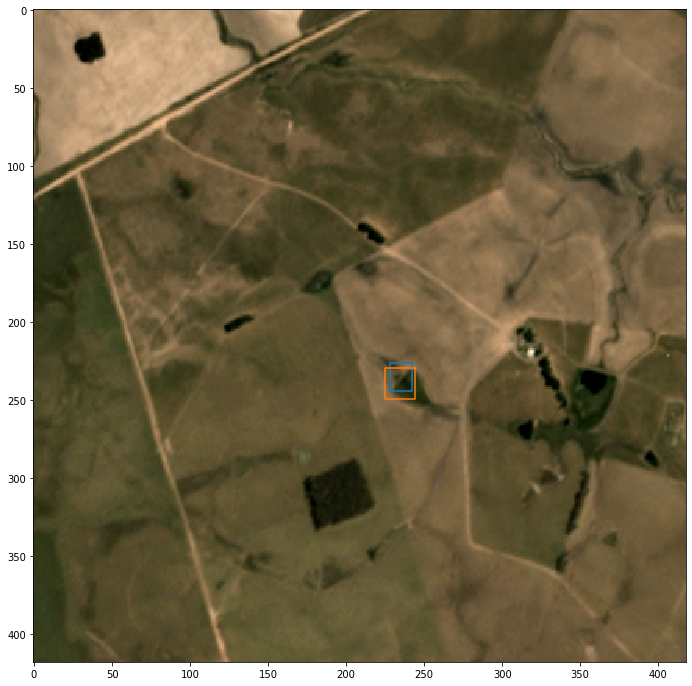

In [130]:
# visualize
from shapely.geometry import box
img_fn = '116826.png'
img_fp = os.path.join(images_dir, img_fn)
img = mpimg.imread(img_fp)
gt_coords = ground_truth_dict[img_fn]
gt_bbox = box(gt_coords[0], gt_coords[1], gt_coords[2], gt_coords[3])
x_gt,y_gt = gt_bbox.exterior.xy
pred_coords = predicted_dict[img_fn]
pred_bbox = box(pred_coords[0], pred_coords[1], pred_coords[2], pred_coords[3])
x_pr,y_pr = pred_bbox.exterior.xy
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(1,1,1)
ax1.imshow(img)
ax1.plot(x_gt,y_gt)
ax1.plot(x_pr,y_pr)

# ground truth in blue
# predicted in orange